# Manipulating Layers of ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook provides an overview of the functionality included in the **ariaExtract.py** program. Specifically, we give examples on how to extract data and meta-data layers from ARIA Geocoded UNWrapped interferogram (GUNW) products over a user defined area of interest. In addition, we provide an overview of the methodology applied to manipulate specific data and meta-data layers. In this notebook, we use GUNW products spanning the May 4, 2018 Hawaii earthquake. 

In this notebook, we will demonstrate how to extract:
- Product bounding boxes
- Imaging geometry layers (i.e., azimuth angle, incidence angle, look angle, perpendicular baseline)
- Data layers (i.e., amplitude, coherence, unwrapped phase, and connected components)

We also provide examples on the various methods of defining a spatial area of interest:
- Union (in space and time) of all products 
- A bounding box defined as South North West East coordinates
- A bounding box in the form of a vector shapefile.

    
<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. All other sections (examples and applications) do not need to be run in order.
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format" on GUNW products. Verify GDAL version >= 3.
- ARIA-tools needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: An image acquired by the satellite for a given date and time.
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *Frame*: Outline of a product ground footprint.
- *Along-track*: The direction along satellite flight path. 
    </div>
    

## Table of Contents:
<a id='example_TOC'></a>

[**Overview of the ariaExtract.py program**](#overview)

[**Methods used in the ariaExtract.py program**](#methods)
- [Extraction of layers without need for manipulation](#method_1)
- [Extraction of full resolution meta-data layers](#method_2)
- [Extraction of unwrapped phase (and connected components) layer](#method_3)

[**Examples of the ariaExtract.py program**](#examples)
- [Example 1. Extracting and viewing of the interferogram outline](#example_1)
- [Example 2. Extracting a layer by spatial subsetting](#example_2)
    - [Extract amplitude with default parameters (intersection)](#example_2_1)
    - [Extract coherence with Bounding Box (SNWE)](#example_2_2)
    - [Extract incidence angle with shape file](#example_2_3)
- [Example 3. Downloading a mask](#example_3)
- [Example 4. Downloading a DEM](#example_4)


[**Applications**](#applications)
- [Application 1. ENU conversion factors](#application_1)
- [Application 2. Computing displacement map](#application_2)

## Prep A. Initial setup of the notebook

Below we set-up the directory structure for this notebook exercise. In addition, we load the required modules into our python environment using the **`import`** command. We also explicitly enable exceptions for GDAL as this allows us to capture GDAL errors.

In [2]:
import os
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

    

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# within workfid the following directories will be created
data_dir = 'data'
res_dir  = 'results'

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.shapefile_util as shputil
except:
    raise Exception('ARIA-tools is missing from your PYTHONPATH')

# generate all the folders in case they do not exist yet
for i in [work_dir, os.path.join(work_dir,data_dir), os.path.join(work_dir,res_dir)]:
    if not os.path.exists(i): os.makedirs(i)
        
os.chdir(work_dir)

Work directory:  /data/ssangha/git_work/ARIA-tools-docs/JupyterDocs/ariaExtract
Tutorial directory:  /data/ssangha/git_work/ARIA-tools-docs/JupyterDocs/ariaExtract


Below we define a plotting function that will be used throughout the notebook for plotting GDAL compatible datasets on a map.

In [3]:
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """ 
        path_layers is a string to the GDAL compatible dataset to be plotted
    """
    
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000 
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'): 
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=0
        vmax=1
        cmap='Greys'
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## Prep B: Download the data

We will use the Big Island of Hawaii as the study area for this tutorial. Specifically, we will look at an interferogram spanning the May 4, 2018 earthquake that occurred on the South-East corner of the island (see **Fig. 1** for the USGS shakemap). 

ARIA provides unwrapped interferograms as GUNW products. As the spatial extent of a product is roughly the size of a Sentinel-1 SLC frame (250km x 250km), it is likely that an interferogram over your study area is composed of multiple adjacent GUNW frames or products. For example, for our study area we will use a Sentinel-1 interferogram generated on track 124, spanning from 20180408 through 20180502, which consists out of two GUNW products or frames.

<img src="support_docs/Hawaii_shakemap.png" alt="region" width="500">
<blockquote><b>Fig. 1</b> Shakemap of coseismic earthquake that occurred on May 4, 2018 in the southeastern corner of the Hawaiian Big Island. </blockquote>

### ARIA GUNW products

The GUNW product is an InSAR surface displacement product derived from Sentinel-1 SAR data and packaged as netCDF4 files. These products contain both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/node/97).

### Download options

### Tutorial dataset 

GUNW products are hosted at the ASF DAAC and can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and as beta products from the [ASF DAAC data search page](https://search.asf.alaska.edu/#/). If you know the GUNW filename of the product, you can also build a download link by appending the GUNW filename to **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/** . 

Alternatively, you can use the **`ariaDownload.py`** program provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria. For a full description of the **`ariaDownload.py`** program, see the [ariaDownload Tutorial](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaDownload/ariaDownload_tutorial.ipynb).

<div class="alert alert-warning">
<b>Potential download failure:</b> 
GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications
</div>

Below we will use the **`ariaDownload.py`** to download the all the GUNW products on track 124 (**`-t`** option) for the interferogram pair *20180408_20180502* (**`--ifg`** option) into a *products* folder (**`-w`** option).

<div class="alert alert-danger">
<b>Download</b>:     
    
- The ***jupuyter notebook* does not allow for interactive entering of your user-name and password, use the *jupyter terminal* instead** with the same command for interactive use.
</div>

In [5]:
!ariaDownload.py -t 124 -w products --ifg 20180408_20180502 -v

https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&output=JSON&relativeOrbit=124
Found: S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1
Found: S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Re-using previous cookie jar.
 > Download file S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc. 
 > Download file S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc. 


Download Summary 
--------------------------------------------------------------------------------
  Suc

We can now have a look at the downloaded products:

In [6]:
!ls products

S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc
S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc


The product filename has two fields, **XXYYYN/S-XXYYYN/S**, that are respectively associated with the western edge of south and north most corner of the geocoded interferogram (see [aria-website](https://aria.jpl.nasa.gov/node/97) for a complete overview of the filename convention). The latitude bounds are specified as 5-digit number with 3 significant digits.

Based on the filename of the two products, can you confirm the products are overlapping?

## Overview of the ariaExtract.py program
<a id='overview'></a>

The **`ariaExtract.py`** program allows for easy extraction of data and meta-data layers from ARIA standard GUNW products. The program will automatically determine which GUNW products need to be stitched or cropped in order to generate a seamless interferogram. By default, interferograms will be cropped to bounds determined by the common intersection and bounding box (if specified). Running **`ariaExtract.py`** with the **`-h`** option will show the parameter options. 

Let us explore these options:

In [7]:
!ariaExtract.py -h

usage: ariaExtract.py [-h] -f IMGFILE [-w WORKDIR] [-tp TROPO_PRODUCTS]
                      [-l LAYERS] [-d DEMFILE] [-p PROJECTION] [-b BBOX]
                      [-m MASK] [-at AMP_THRESH] [-nt NUM_THREADS]
                      [-of OUTPUTFORMAT] [-croptounion] [-verbose]

Program to extract data and meta-data layers from ARIA standard GUNW products.
Program will handle cropping/stitching when needed. By default, the program
will crop all IFGs to bounds determined by the common intersection and bbox
(if specified)

optional arguments:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is
                        local directory where script is launched.
  -tp TROPO_PRODUCTS, --tropo_products TROPO_PRODUCTS
                        Path to director(ies) or tar file(s) containing GACOS
                        pro

### 1. Product files to be used (-f option)

At minimum, users need to specify the GUNW files they want to extract information from. This is controlled using the **`-f`** option. Multiple products can be specified by providing them as a comma separated string (e.g., **`-f`**` 'S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc,S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc'`), or using a wildcard (e.g., **`-f`**` 'S1*.nc'`).

### 2. Layers to be extracted (-l option)

By default, no layers are extracted aside from the bounding boxes of the products. Layer extraction is controlled using the **`-l`** option. Valid options are "unwrappedPhase", "coherence", "amplitude", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle". Multiple layers can be extracted at once by specifying them as a comma separated string (e.g., **`-l`**` 'azimuth,coherence'`). You can use the `'all'` keyword to extract all possible layers at once (e.g., **`-l`**` all`).

### 3. DEM (-d and -p options)

By specifying the **`-d`**` Download` option, users can download the SRTM 3-arcsec DEM on the fly. The DEM will be cropped over the interferogram extent (ground swath). A DEM is required for extracting the meta-data layer fields (e.g., "bPerpendicular", "bParallel", "incidenceAngle","lookAngle", and "azimuthAngle"). Alternatively, users can also specify the location to a custom GDAL-compatible DEM and control its projection by specifying it with the **`-p`** option. All the meta-data layers are stored within the GUNW product as 3D data cubes (longitude, latitude, height). The full-resolution meta-data layers are generated by intersecting these 3D data-cube with the DEM.

### 4. Mask (-m option)

By specifying the **`-m`**` Download` option, users can download a waterbody mask compiled from the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG) on the fly. The mask will be cropped over the interferogram extent (ground swath). A mask is useful for masking out broader waterbodies (e.g. oceans and major lakes) from your output layers. Alternatively, users can also specify the location to a custom GDAL-compatible mask and control its projection by specifying it with the **`-p`** option.

### 5. Cropping and spatial sub setting (-b and -croptounion options)

The **`ariaExtract.py`** program will automatically handle cropping and stitching of GUNW products when needed. By default, the program will crop all interferograms to bounds determined by the common intersection (of all interferograms) and the user-defined bounding box option. All layers are cropped and/or stitched using GDAL (see the methods section for details on the implemented approach for each layer). Below we discuss which options are available for specifying an area-of-interest.

#### Interferogram intersection versus union (-croptounion option)

GUNW products are grouped in clusters that belong to the same interferometric pair. By default, the spatial **intersection** of the interferometic pairs is used to define the region of interest. This can be overwritten to be the union of all interferograms (regardless of alignment) by passing the **`--croptounion`** argument. A schematic example is shown in **Fig 2** for both scenarios.

<div class="alert alert-warning">
<b>Warning:</b> Users in general should avoid mixing products of adjacent satellite tracks (i.e., products made on the same contiguous pass are ok). Note that along the equator, the track number (ascending data on the ascending note) gets incremented while the data itself is still continuous.
</div>

<img src="support_docs/spatial_config_new.png" alt="spatial_configuration" width="700">
<blockquote> <center><b> Fig. 2 </b> Schematic of the spatiotemporal configuration for three interferograms. The left panel shows the intersection of the interferograms, which is the default behavior. The right panel shows the union of the interferograms, achieved by passing <b><code>--croptounion</code></b> . The blue dashed line demonstrates the behavior if the user had specified a bounding box (<b><code>-b</code></b>). Note that interferograms which do not cover the bounding box completely with the <b><code>--croptounion</code></b> or the <b><code>-b</code></b> option, will be padded with no-data values.</center></blockquote>

#### Bounding Box (-b option)

The user can specify a rectangular bounding box (South-North-West-East coordinates) as **`-b`**` 'S N W E'` or can provide a more complex area of interest using a shapefile or geoJSON as **`-b`**` path_to_file.shp`. A schematic example is shown in **Fig 3** for both scenarios.

<img src="./support_docs/crop.png" alt="cropping" width="700">
<blockquote><center><b> Fig. 3 </b> Schematic examples of the <b><code>-b</code></b> option available for cropping. The blue dashed line shows the user-specified area of interest. The left panel demonstrates the result when specifying SNWE coordinates, while the right panel shows the result when specifying a more complex polygon for the area of interest using a shapefile. </center></blockquote>

### 6. Workdirectory (-w option)

The output of the **`ariaExtract.py`** program is saved within the working directory (**`-w`**), which by default is the current directory. Within the work directory the outputs are organized in separate subdirectories, where the sub-directory name corresponds to the layer being extracted. Within each subdirectory, the data and meta-data are saved with the interferogram pair dates "date1_date2" serving as the basename.

### 7.  Output format (-o option)

The **`ariaExtract.py`** program leverages GDAL for file reading and writing of outputs. The user can therefore specify any GDAL compatible format (e.g., ENVI, ISCE, GTiff; see GDAL for more information on supported formats) for saving the outputs from **`ariaExtract.py`**.  By default, "unwrappedPhase", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle" are stored as ENVI files, as these layers required  mathematical manipulation. Other layers including "coherence" and "amplitude" do not require this, and by default are stored as virtual files (.vrt) to conserve disk space.

## Methods used in the ariaExtract.py program
<a id='methods'></a>

The **`ariaExtract.py`** program will automatically handle the stitching and cropping of layers based on a user area of interest, and the union or intersection of all interferograms. The start and stop product sensing times contained within each GUNW product is used to figure out which GUNW products form a single, contiguous interferogram. As all GUNW products are provided on an uniform grid (in sampling and origin), there is no need for resampling. 

The method used for stitching the data and meta-data layers for a given interferogram varies depending on the layer. Three main variants exist:
1. Extraction of layers without need for manipulation (amplitude and coherence).
2. Extraction of full resolution meta-data layers (bPerpendicular, bParallel, incidenceAngle, lookAngle, and azimuthAngle).
3. Extraction of unwrapped phase (and connected component) layer.

Below we elaborate on each of these variants.

### 1.  Extraction of layers without need for manipulation
<a id='method_1'></a>

The *amplitude* and *coherence* layers are stitched together using a mosaicking approach leveraging GDAL **`gdalwarp`** functionality. The stitched layer data in the product overlap region is constrained by one of the two overlapping products without loss of information.

### 2. Extraction of full resolution meta-data layers
<a id='method_2'></a>

The imaging geometry meta-data layers such as *bPerpendicular, bParallel, incidenceAngle, lookAngle,* and *azimuthAngle* are provided within each GUNW product as 3D-data cubes. Since the imaging geometry meta-data layers vary smoothly in space, they are specified with sparse lateral (0.1 arcsec) sampling on fixed height levels (-1.5, 0, 3 and 9 km) for data reduction purposes. 

The full resolution meta-data layer is retrieved by intersecting the 3D data-cube with a DEM (see **Fig. 4**). Users can either provide a custom DEM or specify the DEM download option to retrieve and use the SRTM 3-arcsec DEM. The DEM is interpolated (nearest neighbor) to the native grid of the interferogram. Prior to the intersection of the DEM with the 3D dataset, we mosaic the 3D-data cubes of the different GUNW products together for each interferogram. The intersection itself is done by performing a bivariate spline interpolation laterally and a cubic interpolation vertically to calculate the values at the DEM grid nodes.

<img src="support_docs/interp_2d.png" alt="interp_sketch" width="600" >
    <blockquote> <b>Fig. 4</b> Schematic example of the 3D meta-data cube and intersection routine with a DEM to retrieve the full resolution meta-data layer. Not drawn to scale.</blockquote>

### 3. Extraction of unwrapped phase (and connected components) layer
<a id='method_3'></a>

An interferogram is  generated through the complex multiplication of the reference SLC with the complex conjugate of the secondary SLC, and thus is a wrapped image between $-\pi$ and $\pi$. As part of the unwrapping procedure, a continuous surface is created from the wrapped data by adding integer multiples of 2$\pi$ to its pixels. Unwrapping is not a trivial process, and complicated by (decorrelation) noise in data. As part of the processing routine, a slant range pixel offset correction is estimated from the data, leading to a planar phase correction of small slope in the range direction (perpendicular to the satellite flight direction).

Since each GUNW product is processed and unwrapped separately, we need to account for an integer multiple of 2$\pi$ between GUNW products, and also correct for an additional bias introduced by range offset differences applied to each GUNW product. Both corrections are estimated from product overlap regions, after which we stitch products leveraging GDAL. We maintain the qualitative function of the connected component layer by adjusting each GUNW product connected component layer, while merging all the connected component 0s together.

<img src="support_docs/2frame_overlap.png" alt="overlap" width="30%" >
   <center> <b>Fig. 5</b> Schematic showing overlap region (shaded in red) used to estimate both a phase bias and integer multiple of 2$\pi$ correction between two GUNW products forming a single interferogram (blue and green outline, respectively). </center>

## Examples of the ariaExtract.py program<a id='examples'></a>

### Example 1. Extracting and viewing of the interferogram outline <a id='example_1'></a>

[Back to Example Table of Contents](#example_TOC)

The **`ariaExtract.py`** program groups GUNW products into spatially-temporally continuous interferograms. Even without extracting any layers, **`ariaExtract.py`** will create geoJSON shape files outlining the spatial extent for each interferogram. Below we demonstrate this on the two coseismic GUNW products using default parameters for the spatial sub-setting. 

In [6]:
!ariaExtract.py -f "products/*.nc"

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
No layers specified; only creating bounding box shapes
Thread count specified for gdal multiprocessing = 2


Within the *productBoundingBox* subdirectory, the outline for each stitched interferogram is saved as a geoJSON file using the acquisition dates to form the filename (e.g. '20180502_20180408.shp'). 

In addition, a final bounding box 'productBoundingBox.shp' is stored which details the spatial extent to which all interferograms will be cropped. By default, the *intersection* of the interferograms is used to determine the spatial extent. In our example, only one interferogram is considered without specifying additional options to subset in space (such as the **`--bbox`** option) so both files are identical.

In [7]:
!ls productBoundingBox

20180502_20180408.shp  productBoundingBox.shp


We will view the outline saved in the geoJSON file, with the **`plot_shapefile`** function within **`shapefile_utils.py`** distributed with the ARIA-tools package.

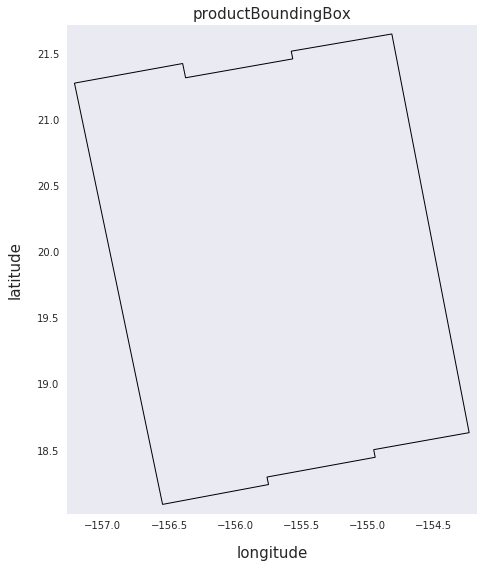

In [9]:
shputil.plot_shapefile(os.path.join('productBoundingBox', 'productBoundingBox.shp'))

### Example 2. Extracting a layer by spatial subsetting
<a id='example_2'></a>

[Back to Example Table of Contents](#example_TOC)

Layers are extracted to separate subdirectories named after the 'layer name' under the specified working directory (`-w`), e.g. 'results/amplitude'. Within the layer subdirectories, the data and meta-data are saved with a given interferometric date combination serving as the filename, e.g. 'results/amplitude/20180502_20180408'. Any existing layers will be overwritten. Below, examples are provided by spatial subsetting using default parameters (intersection), bounding box, and shapefile.

#### 1. Extract amplitude with default parameters (intersection)
<a id='example_2_1'></a>

Below we will extract the *amplitude* layer using default parameters (intersection of common area to all interferograms).

In [9]:
!ariaExtract.py -f "products/*.nc" -l amplitude 

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Generating: amplitude


The extracted amplitude layer is stored within the *amplitude* folder and with the interferometric date combination as its filename. Note that amplitude is one of the layers which is stitched *virtually* by default. The *20180502_20180408_uncropped.vrt* is the complete stitched variant, while the other *20180502_20180408.vrt* file contains the amplitude layer as cropped over the `productBoundingBox.shp` (see [example 1](#example_1) for details).

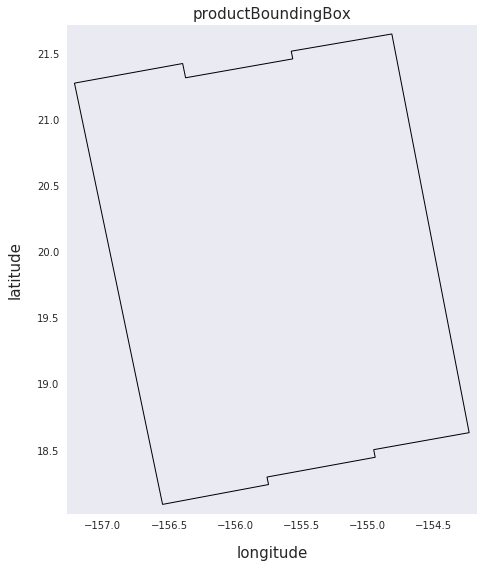

In [10]:
shputil.plot_shapefile(os.path.join('productBoundingBox', 'productBoundingBox.shp'))

In [11]:
!ls amplitude

20180502_20180408_uncropped.vrt  20180502_20180408.vrt


We can now use our earlier defined plotting function to visualize the amplitude of the stitched interferogram.

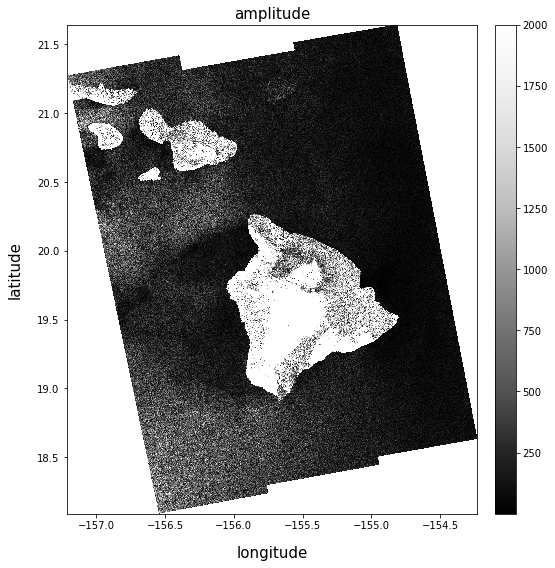

In [12]:
plot_layer(os.path.join('amplitude', '20180502_20180408.vrt'))

The amplitude corresponds to the complex magnitude of the interferogram. Darker colors indicate weaker backscatter of the radar signal, which depend on the characteristics of the surface. In rough water the amplitude will be brighter than in calm sea, as waves will be scattering part of the energy back. Over land, vegetated areas will appear darker compared to urban and mountain outcrops.

#### 2. Extract coherence with Bounding Box (SNWE)
<a id='example_2_2'></a>

Users can specify an area of interest as `SNWE` coordinates using the **`--bbox`** option. Coordinates should be specified as a space delimited string surround by quotes. The example below extracts the coherence over the main island of Hawaii.

In [13]:
!ariaExtract.py -f "products/*.nc" -l coherence   --bbox "18.8 20.3 -156.1 -154.8"

***Extract Product Function:***
Shapefile ./user_bbox.shp created for input user bounds.
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Generating: coherence


The extracted coherence layer is stored within the *coherence* folder and with the interferometric date combination as its filename. As with the amplitude layer, coherence is one of the layers which is stitched *virtually* by default. The *20180502_20180408_uncropped.vrt* is the complete stitched variant, while the other *20180502_20180408.vrt* file contains the coherence layer as cropped over the *productBoundingBox.shp*, which is now cropped to the specified SNWE coordinates (see [example 1](#example_1) for details on the *productBoundingBox*).

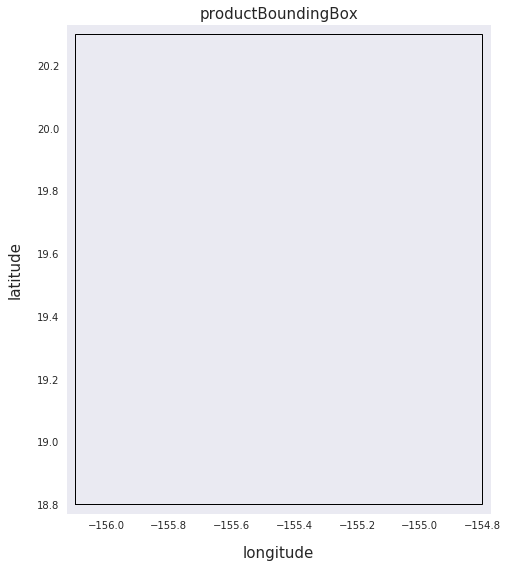

In [14]:
shputil.plot_shapefile(os.path.join('productBoundingBox', 'productBoundingBox.shp'))

In [15]:
!ls coherence

20180502_20180408_uncropped.vrt  20180502_20180408.vrt


The spatial extent of the coherence file can be confirmed by running **`gdalinfo`** on the vrt of the coherence layer.

In [16]:
!gdalinfo coherence/20180502_20180408.vrt

Driver: VRT/Virtual Raster
Files: coherence/20180502_20180408.vrt
       coherence/20180502_20180408_uncropped.vrt
Size is 1560, 1800
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.099999999999994,20.300000000000001)
Pixel Size = (0.000833333333333,-0.000833333333333)
Corner Coordinates:
Upper Left  (-156.1000000,  20.3000000) ( 20d18' 0.00"E,156d 6' 0.00"S)
Lower Left  (-156.1000000,  18.8000000) ( 18d48

Alternatively, the coherence layer can be visualized to show the spatial extent as well.

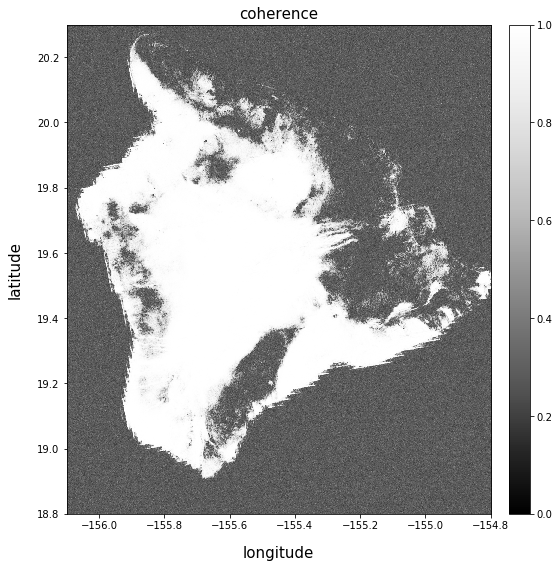

In [17]:
plot_layer(os.path.join('coherence', '20180502_20180408.vrt'))

The coherence is a qualitative marker for the interferogram, ranging between 0 and 1. 
Changes in the acquisition geometry and scattering (e.g. vegetation) lead to decorrelation. The higher the decorrelation, the lower the coherence, as can be observed over the vegetated regions of Hawaii. Coherence is computed using a 5 x 5 window on multi-looked data (~90 m resolution), and therefore its spatial resolution is rather on the order of 450 m. The coarseness of the estimation window can clearly be observed along the water-land boundary.  

#### 3. Extract incidenceAngle with shapefile
<a id='example_2_3'></a>

[Back to Example Table of Contents](#example_TOC)

Users can specify an area of interest using a shapefile through the **`--bbox`** option. The shapefile should be saved as a polygon geometry, compatible with GDAL, and with **WGS84** as reference. Here, we use a shapefile containing the Big Island of Hawaii, created from the [OpenStreetMap dataset](https://www.openstreetmap.org/) using the [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) python library. We will use GDAL's **`orginfo `** to verify its contents:

In [18]:
shp    = os.path.join(tutorial_home_dir, 'data', 'Big_Island', 'Big_Island.shp')
!ogrinfo -so {shp} Big_Island

INFO: Open of `/data/ssangha/git_work/ARIA-tools-docs/JupyterDocs/ariaExtract/data/Big_Island/Big_Island.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Big_Island
Metadata:
  DBF_DATE_LAST_UPDATE=2019-05-09
Geometry: Polygon
Feature Count: 1
Extent: (-156.061881, 18.910620) - (-154.806698, 20.268474)
Layer SRS WKT:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
Data axis to CRS axis mapping: 2,1
bbox_east: String (80.0)
bbox_north: String (80.0)
bbox_south: String (80.0)
bbox_west: String (80.0)
place_name: String (108.0)


Below we extract the *incidenceAngle* layer using this shapefile, which outlines the entire island. Since this is a geometry meta-data layer, a DEM needs to be provided using the **`-d `** option. Note, in case you already have downloaded a DEM, you could now update and specify the path to the DEM file directly, e.g., **`-d `**`DEM/SRTM_3arcsec.dem`.

In [19]:
print('ariaExtract.py -f "products/*.nc" -l incidenceAngle  -d Download -b {}'.format(shp))
!ariaExtract.py -f "products/*.nc" -l incidenceAngle  -d Download -b {shp}

ariaExtract.py -f "products/*.nc" -l incidenceAngle  -d Download -b /data/ssangha/git_work/ARIA-tools-docs/JupyterDocs/ariaExtract/data/Big_Island/Big_Island.shp
***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Downloaded 3 arc-sec SRTM DEM here: ./DEM/SRTM_3arcsec.dem
Generating: incidenceAngle


The extracted incidence angle is stored within the *incidenceAngle* folder and with the interferometric date combination as its filename. Unlike coherence and amplitude, the meta-data layers are physically written out as *ENVI* files, and cropped to the *productBoundingBox.shp*, which is now cropped to the specified shapefile (see [example 1](#example_1) for details on the *productBoundingBox*). The output format can be controlled using the **`-of`** option.

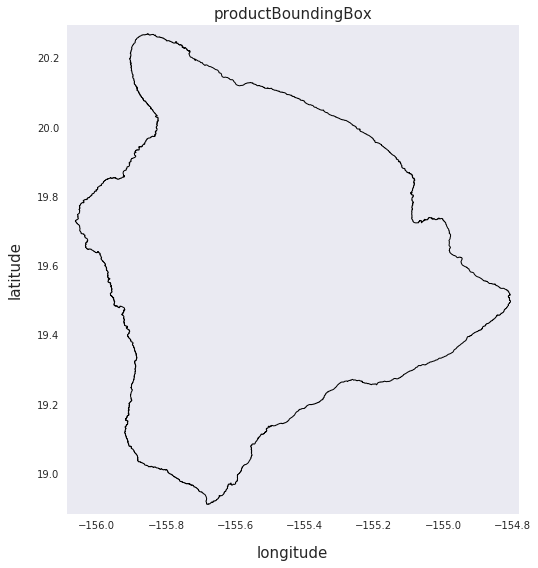

In [20]:
shputil.plot_shapefile(os.path.join('productBoundingBox', 'productBoundingBox.shp'))

In [21]:
!ls incidenceAngle/*

incidenceAngle/20180502_20180408	  incidenceAngle/20180502_20180408.hdr
incidenceAngle/20180502_20180408.aux.xml  incidenceAngle/20180502_20180408.vrt


The spatial extent of the incidence angle file, as well as the no-data value, can be retrieved using **`gdalinfo`** on the vrt of the incidence angle file.

In [22]:
!gdalinfo incidenceAngle/20180502_20180408.vrt

Driver: VRT/Virtual Raster
Files: incidenceAngle/20180502_20180408.vrt
       incidenceAngle/20180502_20180408
Size is 1506, 1629
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.061881300000010,20.268474200000000)
Pixel Size = (0.000833455046481,-0.000833550951504)
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-156.0618813,  20.2684742) ( 20d16' 6.51"E,156d 3'42.77"S)
Lower L

Below we will visualize the incidence angle as extracted over the main island.

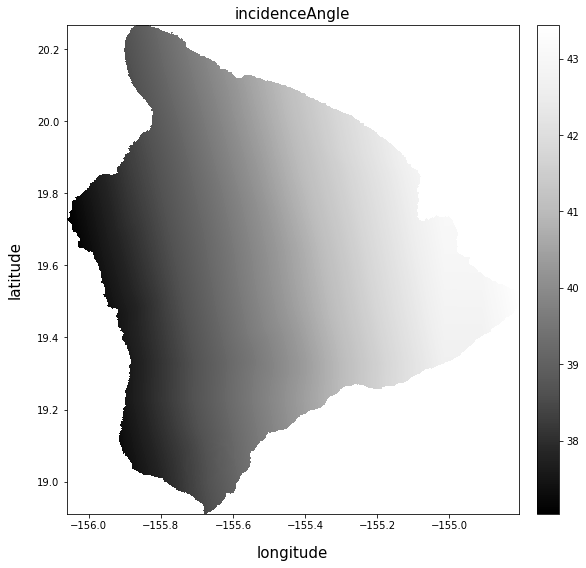

In [23]:
plot_layer(os.path.join('incidenceAngle', '20180502_20180408'))

The incidence angle is reported in degrees and corresponds to the angle between the vertical from the ground and the incomming radar raypath. As can be observed from the figure, anything outside the outline of the island (as delineated by the input shapefile 'data/Big_Island/Big_Island.shp') has been cropped out.

### Example 3. Downloading a mask
<a id='example_3'></a>

[Back to Example Table of Contents](#example_TOC)

To download a waterbody mask compiled from GSHHG, specify the **`-m Download`** option. By default outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The mask will be used to mask all extracted layers. Running the following command to completion will take ~3 mins, so it will be a great time to take a coffee/twitter break:

In [14]:
!ariaExtract.py -f "products/*.nc" -m download

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
No layers specified; only creating bounding box shapes
Thread count specified for gdal multiprocessing = 2


The mask is cropped to the common interferometric grid, stored under local subdirectory *mask*, and given the filename *watermask.msk* (i.e. nested as *mask/watermask.msk*). Note that for consistency, if a user specifies a path to a custom mask, the cropped version is still stored under the local subdirectory *mask* and shares the same filename as the input.

Execute the next cell to visualize the mask. Broader waterbodies (e.g. oceans and major lakes) are delineated in the mask.

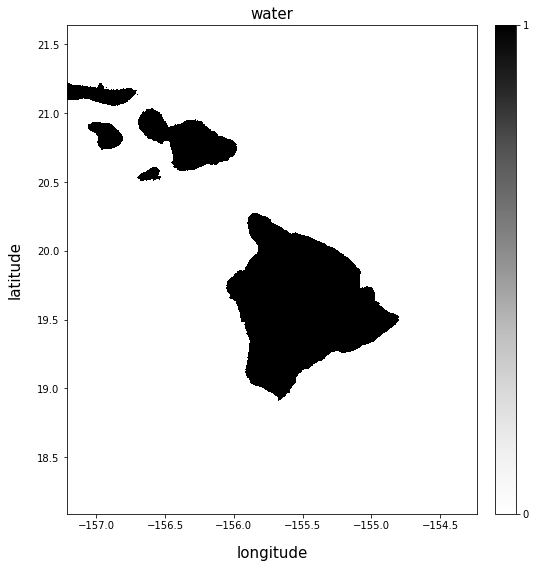

In [67]:
plot_layer('mask/watermask.msk',lay_type='water')

Below we will apply this mask to the unwrapped phase layer.

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Generating: unwrappedPhase


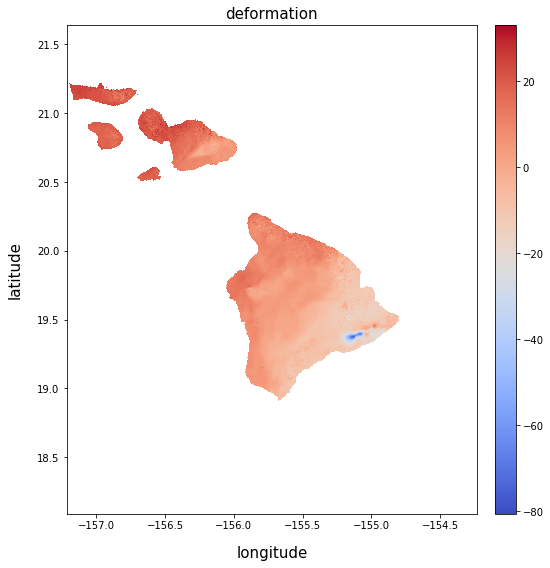

In [32]:
# extract masked unwrapped phase layer
!ariaExtract.py -f "products/*.nc" -l unwrappedPhase -m mask/watermask.msk

## view the plot
plot_layer('unwrappedPhase/20180502_20180408', 'deformation')

### Example 4. Downloading a DEM
<a id='example_4'></a>

[Back to Example Table of Contents](#example_TOC)

To download a 3-arc second SRTM DEM specify the **`-d Download`** option. By default outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The DEM will be needed for the extraction of the full resolution meta-data layers.

Users can specify an area of interest using a shapefile through the **`--bbox`** option. The shapefile should be saved as a polygon geometry, compatible with GDAL, and with **WGS84** as reference. Here, we use a shapefile containing the Big Island of Hawaii, created from the [OpenStreetMap dataset](https://www.openstreetmap.org/) using the [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) python library. This shapefile will clip out the sea surrounding the island.

In [6]:
shp    = os.path.join(tutorial_home_dir, 'data', 'Big_Island', 'Big_Island.shp')
!ariaExtract.py -f "products/*.nc" -d download -b {shp}

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
No layers specified; only creating bounding box shapes
Thread count specified for gdal multiprocessing = 2
Downloaded 3 arc-sec SRTM DEM here: ./DEM/SRTM_3arcsec.dem


The DEM is cropped to the common interferometric grid, stored under local subdirectory *DEM*, and given the filename *SRTM_3arsec.dem* (i.e. nested as *DEM/SRTM_3arsec.dem*). Note that for consistency, if a user specifies a path to a custom DEM, the cropped version is still stored under the locale subdirectory *DEM* and shares the same filename as the input. You can use gdalinfo to retrieve information on the geospatial extent of the DEM. 

In [7]:
!ls DEM/SRTM*
!gdalinfo DEM/SRTM_3arcsec.dem.vrt

DEM/SRTM_3arcsec.dem	      DEM/SRTM_3arcsec.hdr
DEM/SRTM_3arcsec.dem.aux.xml  DEM/SRTM_3arcsec_uncropped.dem.vrt
DEM/SRTM_3arcsec.dem.vrt
Driver: VRT/Virtual Raster
Files: DEM/SRTM_3arcsec.dem.vrt
       DEM/SRTM_3arcsec.dem
Size is 1506, 1629
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6326]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["Degree",0.0174532925199433]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["Degree",0.0174532925199433]]]
Data axis to CRS axis mapping: 1,2
Origin = (-156.061881300000010,20.268474200000000)
Pixel Size = (0.000833455046481,-0.000833550951504)
Metadata:
  Band_1=Band 1
Corner Coordinates:
Upper Left  (-156.0618813,  20.2684742) (156d 3'42.77"W, 20d16' 6.51"N

Execute the next cell to visualize the DEM.

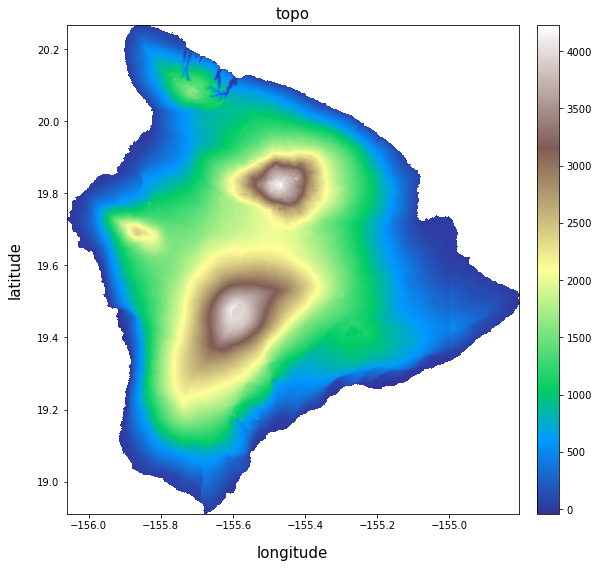

In [21]:
plot_layer('DEM/SRTM_3arcsec.dem',lay_type='topo')

## Applications <a id='applications'></a>

### Application 1.  ENU conversion factors <a id='application_1'></a>

For geophysical modeling and analysis, it is often useful to know how much displacements in the east, north and up directions contribute to the radar line-of-sight (LOS) displacement. The mathematical equations are:

\begin{equation}
E = \sin(\theta)\cos(\alpha+\pi/2), \quad N = \sin(\theta)\sin(\alpha+\pi/2), \quad U = \cos(\theta)
\end{equation}

where $\theta$ is the *incidence angle* and $\alpha$ is the *azimuth angle*. We will extract these meta-data layers over the main island using a shapefile of the island as the bounding box and provide the instruction for downloading a DEM.

In [27]:
shp    = os.path.join(tutorial_home_dir, 'data', 'Big_Island', 'Big_Island.shp')
!ariaExtract.py -f "products/*.nc" -l "incidenceAngle,azimuthAngle"  -d download -b {shp}

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Downloaded 3 arc-sec SRTM DEM here: ./DEM/SRTM_3arcsec.dem
Generating: incidenceAngle
Generating: azimuthAngle


Next, we will use GDAL to load both the *incidence* and *azimuth angles* into python, use **`numpy`** functionality to calculate the east, north and up conversions factors using the equations provided above, and lastly leverage GDAL for writing out the 3-band *enu* file to the *results* folder.

In [28]:
import glob

## setup the paths for the calculation
ifg      = '20180502_20180408'
path_src = [os.path.join(layer, ifg) for layer in ['incidenceAngle', 'azimuthAngle']]
path_dst = os.path.join('results', '{}_enu'.format(ifg))

# removing files
for file in glob.glob(path_dst + '*'):
    os.remove(file)

## loading the data
ds       = gdal.Open(path_src[0], gdal.GA_ReadOnly)
raster = ds.GetRasterBand(1)
try:
    NoData = raster.GetNoDataValue()
except:
    NoData = None
arr_inc  = raster.ReadAsArray()
arr_azi  = gdal.Open(path_src[1], gdal.GA_ReadOnly).ReadAsArray()
NoData_mask = (arr_inc==NoData)
NoData_out = 0


## convert to radians and calculate
arr_incd = np.deg2rad(arr_inc)
arr_azid = np.deg2rad(arr_azi)
E = np.sin(arr_incd) * np.cos(arr_azid + np.pi/2)
N = np.sin(arr_incd) * np.sin(arr_azid + np.pi/2)
U = np.cos(arr_incd)
E[NoData_mask]=NoData_out
N[NoData_mask]=NoData_out
U[NoData_mask]=NoData_out


## copy the projection information into a memory; most formats dont support adding bands
ds_out = gdal.GetDriverByName('MEM').CreateCopy('', ds)

## write ENU to separate bands
description = ['East to LOS','North to LOS','Up to LOS']
for i, j in enumerate([E, N, U]):
    try:
        band = ds_out.GetRasterBand(i+1)
    except:
        # add a float 32 band when it doesn't exist
        ds_out.AddBand(gdal.GDT_Float32)
        band = ds_out.GetRasterBand(i+1)

    j = np.where(np.isnan(j), NoData_out, j)
    band.SetNoDataValue(NoData_out)
    band.WriteArray(j)
    band.SetDescription(description[i])


## write dataset to disk and build a VRT for it
ds = gdal.Translate(path_dst, ds_out, noData=NoData_out, format='ENVI')
gdal.BuildVRT('{}.vrt'.format(path_dst), ds)
del ds, ds_out

In [29]:
ls results/20180502_20180408_enu*

results/20180502_20180408_enu          results/20180502_20180408_enu.hdr
results/20180502_20180408_enu.aux.xml  results/20180502_20180408_enu.vrt


Can you rank the *ENU* conversion magnitude to the Line-of-Sight from large to small?
We will use **`gdalinfo`**` -stats` to verify the mean conversion factors.

In [30]:
!gdalinfo results/20180502_20180408_enu.vrt -stats

Driver: VRT/Virtual Raster
Files: results/20180502_20180408_enu.vrt
       results/20180502_20180408_enu
Size is 1506, 1629
Coordinate System is:
GEOGCRS["GCS_unknown",
    DATUM["D_unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["Degree",0.0174532925199433]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["Degree",0.0174532925199433]]]
Data axis to CRS axis mapping: 1,2
Origin = (-156.061881300000010,20.268474200000000)
Pixel Size = (0.000833455046481,-0.000833550951504)
Corner Coordinates:
Upper Left  (-156.0618813,  20.2684742) (156d 3'42.77"W, 20d16' 6.51"N)
Lower Left  (-156.0618813,  18.9106197) (156d 3'42.77"W, 18d54'38.23"N)
Upper Right (-154.8066980,  20.2684742) (154d48'24.11"W, 20d16' 6.51"N)
Lo

Let's now take a look at the resulting E, N, U rasters

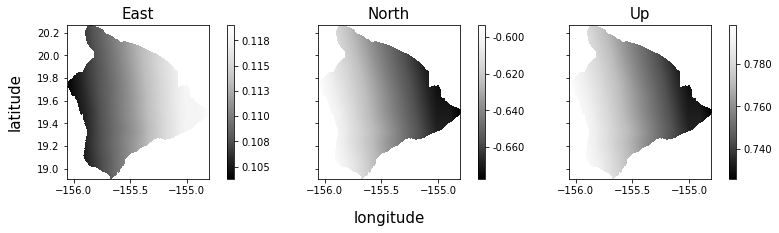

In [31]:
## setup the paths for the calculation
ifg      = '20180502_20180408'
path_src = os.path.join('results', '{}_enu'.format(ifg))
plot_layer(path_src, 'ENU')

### Application 2. Computing displacement map <a id='application_2'></a>

The unwrapped interferogram is provided in radian units. The conversion from interferometric phase, $\varphi$, to line‐of‐sight displacement, $d$, is controlled by $−4\pi/\lambda$  conversion factor as:

$$ d = -\frac{4\pi}{\lambda}   \varphi, $$
   
with $\lambda$ the radar wavelength, and where a minus sign is included to define uplift as a positive displacement. The wavelength is stored within each GUNW product and can be retrieved using the netcdf reader (see  code snippet below for an example), however for simplicity we directly fix it to 5.54 cm.

```
fname='products/S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc'
rdrmetadata = netCDF4.Dataset(fname, keepweakref=True, diskless=True).groups['science'].groups['radarMetaData']
rdrmetadata['wavelength'].getValue()
```

We extract the unwrapped phase using a shapefile over the main island of Hawaii.

In [22]:
shp    = os.path.join(tutorial_home_dir, 'data', 'Big_Island', 'Big_Island.shp')
!ariaExtract.py -f "products/*.nc" -l unwrappedPhase --bbox {shp}

***Extract Product Function:***
All (2) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (1) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Generating: unwrappedPhase
STITCH Settings: Product overlap approach
Solver: Minimize overlap
MAPPING complete:
Input file size is 1506, 1629
Warning 6: PNG driver doesn't support data type Float32. Only eight bit (Byte) and sixteen bit (UInt16) bands supported. Defaulting to Byte

0...10...20...30...40...50...60...70...80...90...100 - done.


Next, we leverage the command line **`gdal_calc.py`** program to calculate the corresponding displacement map in cm by scaling the unwrapped interferogram. The connected component 0s are utilized as a mask. Outputs are written to the *results* folder with *defo* filenames, and visualized with our plotting function.

0.. 0.. 1.. 1.. 2.. 3.. 3.. 4.. 5.. 5.. 6.. 7.. 7.. 8.. 8.. 9.. 10.. 10.. 11.. 12.. 12.. 13.. 14.. 14.. 15.. 16.. 16.. 17.. 17.. 18.. 19.. 19.. 20.. 21.. 21.. 22.. 23.. 23.. 24.. 25.. 25.. 26.. 26.. 27.. 28.. 28.. 29.. 30.. 30.. 31.. 32.. 32.. 33.. 33.. 34.. 35.. 35.. 36.. 37.. 37.. 38.. 39.. 39.. 40.. 41.. 41.. 42.. 42.. 43.. 44.. 44.. 45.. 46.. 46.. 47.. 48.. 48.. 49.. 50.. 50.. 51.. 51.. 52.. 53.. 53.. 54.. 55.. 55.. 56.. 57.. 57.. 58.. 58.. 59.. 60.. 60.. 61.. 62.. 62.. 63.. 64.. 64.. 65.. 66.. 66.. 67.. 67.. 68.. 69.. 69.. 70.. 71.. 71.. 72.. 73.. 73.. 74.. 75.. 75.. 76.. 76.. 77.. 78.. 78.. 79.. 80.. 80.. 81.. 82.. 82.. 83.. 83.. 84.. 85.. 85.. 86.. 87.. 87.. 88.. 89.. 89.. 90.. 91.. 91.. 92.. 92.. 93.. 94.. 94.. 95.. 96.. 96.. 97.. 98.. 98.. 99.. 100 - Done


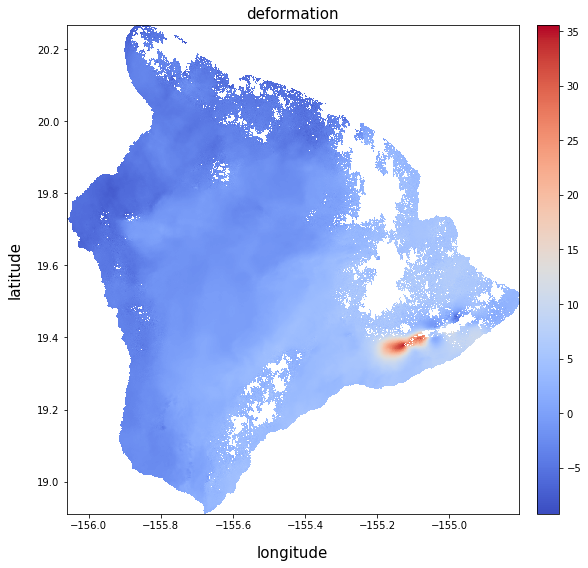

In [25]:
## use gdal_calc.py to perform the calculation
!gdal_calc.py -A unwrappedPhase/20180502_20180408.vrt -B connectedComponents/20180502_20180408.vrt --outfile results/20180502_20180408_defo --calc='((A*(B>0))/(-4*pi)*5.546576)' --format=ENVI --NoDataValue=0 --overwrite

## view the plot
plot_layer('results/20180502_20180408_defo', 'deformation')

Up to 35 cm of displacements can be observed towards the direction of the satellite.